# Multiple linear regression model
### Let's mimic the process of building and evaluating a linear model
### Dataset: https://www.kaggle.com/mirichoi0218/insurance

In [18]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import all stock market data into DataFrame
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Step 1: Check and Clean Data

In [4]:
# Lets check whether do we have NaN values in indicepanel
print('check for null values:')
print(df.isnull().sum())
print('\ncheck data types:')
print(df.dtypes)

check for null values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

check data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [5]:
print(df.sex.unique())
print(df.smoker.unique())
print(df.region.unique())


['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [6]:
cleanup_nums = {
    "sex":     {"male": 0, "female": 1},
    "smoker": {"no":0,"yes":1},
    "Category":{"Dress" :0,"Jacket":1 , "Shoes" : 2,"Skirt":3,"Sweater":4,"Trouser":5,"Underwear":6},
    "region":{"southwest":0,"southeast":1,"northwest":2,"northeast":3}
}

data = df.replace(cleanup_nums, inplace=False)
print("check types of variables after replacing the categorical data with codes;")
print(data.dtypes)
data.head()


check types of variables after replacing the categorical data with codes;
age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object


,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


## Step 2: Explore the data set

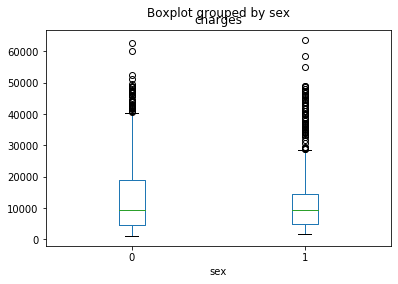

In [7]:
data.boxplot(column = ['charges'], grid=False , by='sex')
plt.show()

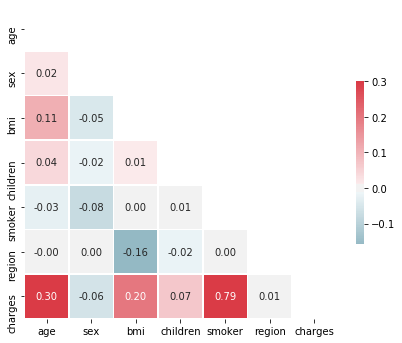

In [8]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association
import seaborn as sns

corr = data.corr(method ='pearson')

# empty the higher diagonal of matrix
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))

f, ax = plt.subplots(figsize=(7, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [9]:
# Find the indice with largest correlation
corr_array = data.corr()['charges']
print(corr_array)

#it seems that region has the smallest correlation with charges

age         0.299008
sex        -0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
region      0.006208
charges     1.000000
Name: charges, dtype: float64


## Step 3: Data Spliting

In [10]:
Train = data.iloc[:1000, :]
Test = data.iloc[1000:, :]

print(Train.shape, Test.shape)

(1000, 7) (338, 7)


## Step 4: Check the correlation of each index between charges

In [11]:
formula = 'charges~age+sex+bmi+children+smoker+region'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     514.6
Date:                Fri, 29 May 2020   Prob (F-statistic):          1.31e-300
Time:                        17:12:15   Log-Likelihood:                -10103.
No. Observations:                1000   AIC:                         2.022e+04
Df Residuals:                     993   BIC:                         2.025e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.361e+04   1157.664    -11.760      0.000   -1.59e+04   -1.13e+04
age          265.0028     13.372     19.818      0.000     238.762     291.243
sex          276.0712    376.943      0.732      0.464    -463.624    1015.767
bmi          332.3475     31.597     10.518      0.000     270.342     394.353
children     415.6631    156.680      2.653      0.008     108.200     723.126
smoker       2.38e+04    474.058     50.203      0.000    2.29e+04    2.47e+04
region       462.0857    170.866      2.704      0.007     126.785     797.387
==============================================================================
Omnibus:                      230.650   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.222
Skew:                           1.230   Prob(JB):                    2.01e-120
Kurtosis:                       5.680   Cond. No.                         321.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Make prediction

In [13]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

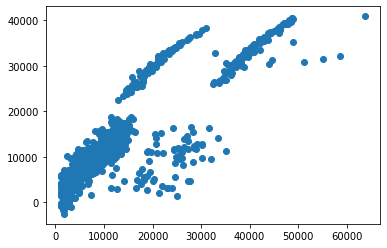

In [14]:
plt.scatter(Train['charges'], Train['PredictedY'])
plt.show()

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE**, **Adjusted $R^2$ **

In [15]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [16]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [17]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'charges')

,Train,Test
R2,0.752503,0.745310
RMSE,5962.880124,6517.509678
